# Import modules

In [1]:
import os
import time
import torch
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from pathlib import Path

from src.data_utils import load_and_preprocess_data
from src.models import Generator, Discriminator
from src.utils import weights_init, compute_gradient_penalty, add_dp_noise_to_gradients

/opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
 in /opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Preview data

In [2]:
class Config:
    # --- Cấu hình thiết bị và dữ liệu ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    IMG_SIZE = 128
    IMG_CHANNELS = 1
    # Đường dẫn dữ liệu trên Kaggle
    DATA_PATH_CSV = "./dataset/nii_paths.csv" 
    LATENT_SIZE = 128

    # --- Cấu hình Training ---
    EPOCHS = 250 # Giảm để chạy nhanh hơn trên Kaggle
    BATCH_SIZE = 32
    LR = 0.0001
    BETA1 = 0.5
    BETA2 = 0.9
    CRITIC_ITERATIONS = 4
    LAMBDA_GP = 10

    # --- Cấu hình Differential Privacy (DP) - Tắt theo mặc định ---
    ADD_DP_NOISE = False
    NOISE_MULTIPLIER = 1.1
    MAX_GRAD_NORM = 1.0
    
    # --- Cấu hình Lưu trữ & Logging ---
    OUTPUT_DIR = Path("/kaggle/working/output")
    SAMPLE_INTERVAL = 500
    MODEL_SAVE_INTERVAL = 25 # Lưu ít thường xuyên hơn
    FIXED_NOISE_SIZE = 64 

config = Config()

In [3]:
dataloader = load_and_preprocess_data(config)

Bắt đầu tải và tiền xử lý dữ liệu MRI...
Đã tải 10000 lát cắt.
Tiền xử lý hoàn tất trong 9.07 giây.
Đang tạo DataLoader...
DataLoader sẵn sàng với 313 batch.


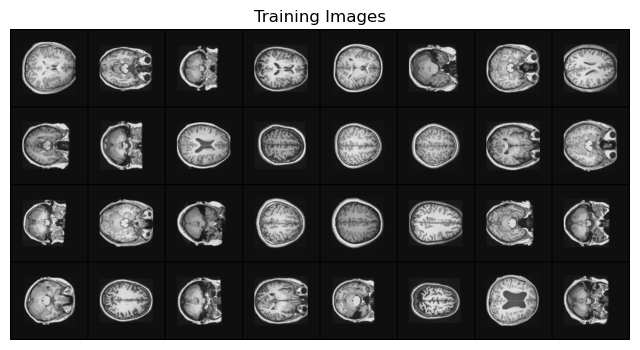

In [4]:
# Hiển thị một batch ảnh để kiểm tra
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(real_batch[0].to(config.DEVICE)[:64], padding=2, normalize=True).cpu().permute(1, 2, 0))
plt.show()

# Create model and optimizer

In [5]:
generator = Generator(config.LATENT_SIZE, config.IMG_CHANNELS, config.IMG_SIZE).to(config.DEVICE)
discriminator = Discriminator(config.IMG_CHANNELS, config.IMG_SIZE).to(config.DEVICE)

generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_g = optim.Adam(generator.parameters(), lr=config.LR, betas=(config.BETA1, config.BETA2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=config.LR, betas=(config.BETA1, config.BETA2))

fixed_noise = torch.randn(config.FIXED_NOISE_SIZE, config.LATENT_SIZE, device=config.DEVICE)